# 1 Sentiment analysis with BERT&GRU

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!nvidia-smi

Tue Mar  7 16:37:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    54W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive')

Preparing the enviroment.This step is also important,because Torchtext Field has been removed in the latest version.We need to install the version of torchtext 0.9.0 and pytorch  1.8.0 with cuda 11.1

In [ ]:
pip install torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.8.0+cu111 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have 

## 1.1 Data preparation

First, as usual, we import the library and set the random seed

In [ ]:
import torch

import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Then determine whether the machine is using a CPU or a GPU for training (this step is critical, if it is a CPU it will take much more time than a GPU for this kind of training)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

True
cuda


Preparing the enviroment.This step is also important,because Torchtext Field has been removed in the latest version.We need to install the version of torchtext 0.9.0 and pytorch  1.8.0 with cuda 11.1

In [ ]:
pip install torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


The Transformer has been trained with a specific vocabulary, which means we need to train with the exact same vocabulary and label our data in the same way as the Transformer was originally trained.

Fortunately, the transformers library has word splitters for each of the provided transformer models. In this case, we use a BERT model that ignores case (i.e. every word will be lowercase). We do this by loading pre-trained "bert-base-uncased" tokens.

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.3 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The `tokenizer` has a `vocab` property which contains the actual vocabulary we will use. We can check how many words are in it by checking its length.

In [ ]:
len(tokenizer.vocab)

30522

Use the `tokenizer.tokenize` method to split the string and standardise the case.

In [ ]:
tokens = tokenizer.tokenize('YoU sHOuLd KNoW mE')

print(tokens)

['you', 'should', 'know', 'me']


We can use our vocabulary to digitise tokens using `tokenizer.convert_tokens_to_ids`. The tokens below are the list after our previous splitting and case-unification above.

In [ ]:
indexes = tokenizer.convert_tokens_to_ids(tokens)

print(indexes)

[2017, 2323, 2113, 2033]


The Transformer is also trained with special tokens to mark the beginning and end of sentences, [details](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel). Just as we normalize padding and unknown tokens, we can also get these from the `tokenizer`.

**Note**: `tokenizer` does have sequence start and sequence end attributes (`bos_token` and `eos_token`), but we don't have this set and it doesn't apply to our transformer for this training.

In [ ]:

init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


We can get an index of special tokens by inverting the glossary

In [ ]:
init_token_idx = tokenizer.convert_tokens_to_ids(init_token)
eos_token_idx = tokenizer.convert_tokens_to_ids(eos_token)
pad_token_idx = tokenizer.convert_tokens_to_ids(pad_token)
unk_token_idx = tokenizer.convert_tokens_to_ids(unk_token)

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


Or get them directly through the tokenizer's methods

In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


The other thing we need to deal with is that the model is trained on sequences with defined maximum lengths - it doesn't know how to handle longer sequences than it is trained on. We can get the maximum length of these input sizes by checking the converter version of `max_model_input_sizes` that we want to use.

In [ ]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


Previously we used the `spaCy` tagger to tag our examples. However, we now need to define a function that we will pass to our `TEXT` field which will handle all the tokenisation for us. It will also reduce the number of tokens to the maximum length. Note that our maximum length is 2 less than the actual maximum length. This is because we need to attach two tokens to each sequence, one at the beginning and one at the end.

In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

Now we start defining our fields, the transformer expects the batch dimension to be on the first dimension, so we set `batch_first = True`. Now that we have the lexical data for the text, provided by the transformer, we set `use_vocab = False` to tell torchtext that we don't need to slice the data anymore. We pass the `tokenize_and_cut` function as the tokenizer. The `preprocessing` argument is a function, and this is where we convert the token to its index. Finally, we define special tokens - note that we define them as their index value rather than their string value, i.e. `100' rather than `[UNK] " this is because the sequence has been converted to an index.

We define the tag fields as before.

In [ ]:
from torchtext.legacy import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

Load the data and split it into a training and validation set

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 8.86MB/s]


In [ ]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


Take a look at a random example to see how this works, outputting a one-hot vector of one of the sentences.

In [ ]:
print(vars(train_data.examples[6]))

{'text': [2129, 2106, 2023, 2412, 2272, 2046, 4598, 1029, 1045, 3227, 2293, 16596, 1042, 1013, 2502, 13064, 3649, 3152, 4385, 1012, 1012, 1012, 2021, 1045, 2145, 5987, 2068, 2000, 2022, 2517, 2302, 3243, 2061, 2172, 8808, 2004, 2023, 1012, 1996, 3896, 2020, 6517, 1010, 1996, 3210, 2020, 6517, 4063, 1012, 4468, 2012, 2035, 5366, 1012, 1045, 2069, 3092, 2039, 9278, 2075, 2009, 2138, 2009, 2001, 1999, 1996, 3308, 2553, 1006, 1045, 2001, 2559, 2005, 1996, 21871, 16211, 10649, 2143, 2007, 9993, 18745, 3385, 1999, 2009, 1011, 1011, 2145, 4033, 1005, 1056, 2464, 2008, 2028, 1007, 1012, 1996, 2801, 1997, 1996, 2143, 2003, 2941, 1037, 2204, 2028, 1012, 2045, 2001, 1037, 2843, 1997, 4022, 2000, 2191, 1037, 2307, 2210, 3185, 2182, 1012, 1045, 2074, 2123, 1005, 1056, 3305, 2129, 2242, 2066, 2023, 4515, 2039, 2066, 2023, 1012, 2175, 3713, 2000, 1996, 2143, 1013, 2840, 1013, 2394, 4699, 2493, 1999, 2151, 2152, 2082, 1998, 2017, 1005, 2222, 2424, 2111, 2040, 2064, 4339, 1037, 2488, 5896, 1012], 'labe

We can use `convert_ids_to_tokens` to convert these indexes back to readable tokens.

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(vars(train_data.examples[6])['text'])

print(tokens)

['how', 'did', 'this', 'ever', 'come', 'into', 'existence', '?', 'i', 'generally', 'love', 'sci', 'f', '/', 'big', '##foot', 'whatever', 'films', 'etc', '.', '.', '.', 'but', 'i', 'still', 'expect', 'them', 'to', 'be', 'written', 'without', 'quite', 'so', 'much', 'cheese', 'as', 'this', '.', 'the', 'effects', 'were', 'sad', ',', 'the', 'lines', 'were', 'sad', '##der', '.', 'avoid', 'at', 'all', 'costs', '.', 'i', 'only', 'ended', 'up', 'rent', '##ing', 'it', 'because', 'it', 'was', 'in', 'the', 'wrong', 'case', '(', 'i', 'was', 'looking', 'for', 'the', 'sas', '##qua', '##tch', 'film', 'with', 'lance', 'henrik', '##son', 'in', 'it', '-', '-', 'still', 'haven', "'", 't', 'seen', 'that', 'one', ')', '.', 'the', 'idea', 'of', 'the', 'film', 'is', 'actually', 'a', 'good', 'one', '.', 'there', 'was', 'a', 'lot', 'of', 'potential', 'to', 'make', 'a', 'great', 'little', 'movie', 'here', '.', 'i', 'just', 'don', "'", 't', 'understand', 'how', 'something', 'like', 'this', 'ends', 'up', 'like', '

Although we have already dealt with vocabularies for text, we will of course need to build vocabularies for tags as well.

In [ ]:
LABEL.build_vocab(train_data)

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


As before, we create the iterator. From past experience, using the largest batch size gives the best results for the transformer, but you can of course try using other batch sizes if you have a better graphics card.

In [ ]:
BATCH_SIZE = 128


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device=device)

# 1.2 Building the model

Next, we import the pre-trained model.

In [ ]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Next, we will define our actual model.

Instead of using an embedding layer, we will use a pre-trained Transformer model to obtain embeddings of the text. these embeddings are then fed into GRU to generate predictions of the sentiment of the input sentence. We obtain the embedding dimension size (called `hidden_size`) from the transformer via its config attribute. The rest of the initialisation is standard.

In the forward pass, we wrap the transformer in a `no_grad` to ensure that gradients are not computed in this part of the model. transformer actually returns the embedding of the entire sequence as well as the *pooled* output. The [Bert model documentation](https://huggingface.co/transformers/model_doc/bert.html#transformers.BertModel) states that the pooled output is "usually not a good summary of the semantic content of the input. You are usually better off averaging or merging the entire sequence of hidden states of the input sequence", so we will not use it. The rest of the forward pass is a standard implementation of the cyclic model, where we take the hidden state at the last time step and pass it to a linear layer to obtain our predictions.

In [ ]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
 
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

We use standard hyperparameters to create instances of the model.

In [ ]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,HIDDEN_DIM,OUTPUT_DIM,N_LAYERS,BIDIRECTIONAL,DROPOUT)

We can check how many parameters the model has. Our standard model has less than 5M parameters, but this model has 112M Fortunately, and with 110M of these parameters coming from the transformer, we don't have to train them again.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


In order to fix the parameters (without training them), we need to set their `requires_grad` property to `False`. To do this, we simply iterate through all the `named_parameters` in the model, setting `requires_grad = False` if they are part of the `bert` converter model, and setting `requires_grad` to `True` if we are fine-tuning

In [ ]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

We can now see that our model has less than 3M trainable parameters. However, the text still has to be propagated through the transformer, which causes the training to take longer.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


We can double check the names of the trainable parameters to make sure they make sense. We can see that they are all parameters of the GRU (`rnn`) and the linear layer (`out`).

In [ ]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
out.weight
out.bias


## 1.3 Training the model

As usual, we construct our own model evaluation criteria (loss function), which is still binary

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.BCEWithLogitsLoss()

Put the model and evaluation criteria (loss function) on the GPU

In [ ]:
torch.cuda.empty_cache()
model = model.to(device)
criterion = criterion.to(device)

Next, we will define functions for: calculating accuracy, defining the train, evalute functions and calculating the time required for each epoch of the training/evaluation period.

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for idx, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

        if (idx+1) % 250 == 0:
          print("====", idx, "acc:", epoch_acc/idx, "loss:", epoch_loss/idx, "====")
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we will train our model. This is much longer than any previous model due to the size of the transformer. Even if we don't train any of the transformer's parameters, we still need to pass data through the model, which can take a lot of time on a standard GPU.

In [ ]:
import matplotlib.pyplot as plt

Epoch: 01 | Epoch Time: 1m 14s
	Train Loss: 0.515 | Train Acc: 73.51%
	 Val. Loss: 0.313 |  Val. Acc: 87.02%
Epoch: 02 | Epoch Time: 1m 14s
	Train Loss: 0.323 | Train Acc: 86.26%
	 Val. Loss: 0.248 |  Val. Acc: 89.94%
Epoch: 03 | Epoch Time: 1m 14s
	Train Loss: 0.268 | Train Acc: 88.96%
	 Val. Loss: 0.233 |  Val. Acc: 90.67%
Epoch: 04 | Epoch Time: 1m 14s
	Train Loss: 0.235 | Train Acc: 90.71%
	 Val. Loss: 0.204 |  Val. Acc: 92.26%
Epoch: 05 | Epoch Time: 1m 14s
	Train Loss: 0.205 | Train Acc: 91.99%
	 Val. Loss: 0.208 |  Val. Acc: 92.11%


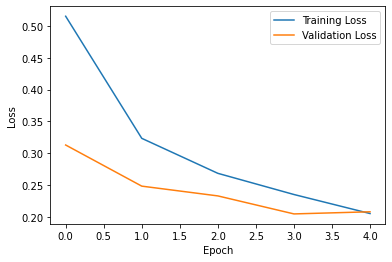

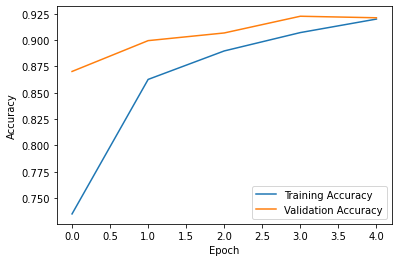

In [ ]:
N_EPOCHS = 5
train_loss_history=[]
valid_loss_history=[]
train_acc_history=[]
valid_acc_history=[]
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    # Save loss and accuracy history
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)
# Plot loss history
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy history
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(valid_acc_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We will load the parameters that provide us with the best loss values on the validation set and apply these parameters on the test set - and achieve the optimal results on the test set.

In [ ]:
model.load_state_dict(torch.load('./tut6-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.202 | Test Acc: 92.18%


## 1.4 Model validation

We will then use the model to test the sentiment of a number of sequences. We tokenise the input sequence, trim it to maximum length, add the special token to either side, convert it to a tensor, add one dimension using the unsqueeze function, and pass it to our model.

In [ ]:
def predict_sentiment(model, tokenizer, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    # return prediction.item()
    if prediction >= 0.75:
      print(prediction.item(),"This sentence represents a strong positive emotion.")
    elif 0.55 < prediction and prediction < 0.75:
      print(prediction.item(),"This sentence represents a weak postive emotion.")
    elif 0.45<= prediction and prediction <= 0.55:
      print(prediction.item(),"This sentence represents a neutral emotion.")
    elif 0.25 < prediction and prediction < 0.45:
      print(prediction.item(),"This sentence represents a weak negative emotion.")
    elif 0 < prediction and prediction <= 0.25:
      print(prediction.item(),"This sentence represents a strong negative emotion.")


Examples of positive comments.

In [ ]:
predict_sentiment(model, tokenizer, "I don't want meet him.")

0.4841388463973999 This sentence represents a neutral emotion.


Examples of negative comments.

In [ ]:
predict_sentiment(model, tokenizer, "Dinner is scrumptious!")

0.32948553562164307 This sentence represents a weak negative emotion.


In [ ]:
import torch
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize

# Set thresholds
threshold = 0.5

# Disable gradient calculation
with torch.no_grad():
    model.eval()
    y_true = []
    y_pred = []

    for batch in test_iterator:
        text = batch.text
        predictions = model(text).squeeze(1)
        # Convert output values to categories
        preds = torch.sigmoid(predictions) > threshold
        y_pred.extend(preds.tolist())
        y_true.extend(batch.label.tolist())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

print(cm)
# Normalised confusion matrix
cm_norm = normalize(cm, axis=1, norm='l1')
print(cm_norm)

[[11279  1221]
 [  731 11769]]
[[0.90232 0.09768]
 [0.05848 0.94152]]


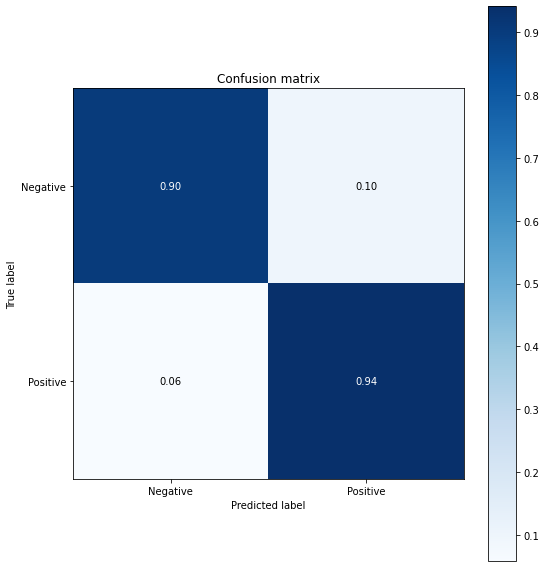

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set up tags
labels = ['Negative', 'Positive']

# Draw confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Add a comment
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], '.2f'),
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Calculation of assessment indicators
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = recall

print(f"Confusion Matrix:\n{cm_norm}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")

Confusion Matrix:
[[0.90232 0.09768]
 [0.05848 0.94152]]
Accuracy: 0.9219
Precision: 0.9060
Recall: 0.9415
Specificity: 0.9023
Sensitivity: 0.9415


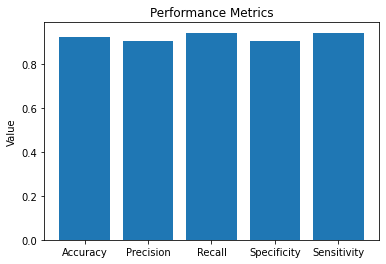

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the assessment indicators from confusion matrix
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
sensitivity = recall

# Putting indicators into arrays for plotting
ind = np.arange(5)
vals = [accuracy, precision, recall, specificity, sensitivity]
labels = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'Sensitivity']

# Plotting bar charts
plt.bar(ind, vals)
plt.xticks(ind, labels)
plt.ylabel('Value')
plt.title('Performance Metrics')
plt.show()
